In [332]:
#%%writefile Cointegration.py
#https://medium.com/@bart.chr/pairs-trading-for-algorithmic-trading-breakdown-d8b709f59372
#https://github.com/aconstandinou/mean-reversion

import statsmodels.api as sm
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import coint
import numpy as np
import pandas as pd
import statistics

import matplotlib.pyplot as plt

# Functions/Methods

In [333]:
"""
Augmented Dickey–Fuller (ADF) unit root test; p-value < .05
"""
class DickeyFuller(object):
    def __init__(self, significance=.05):
        self.significance_level = significance
        self.p_value = None
        self.perc_stat = None
        self.is_stationary = None
        
    def check(self, time_series):
        model = ts.adfuller(time_series, 1)
        self.p_value = model[1]
        statistic = model[0]
        
        # Dickey-Fuller
        self.is_stationary = False
        if (self.p_value < self.significance_level):
            self.is_stationary = True
        
        # Augmented Dickey Fuller (ADF)
        if (abs(statistic) > abs(model[4]['1%'])):
            self.perc_stat = 99
        elif (abs(statistic) > abs(model[4]['5%'])):
            self.perc_stat = 95
        elif (abs(statistic) > abs(model[4]['10%'])):
            self.perc_stat = 90
    
        return self.is_stationary

"""
Half Life test from the Ornstein-Uhlenbeck process 
"""
class HalfLife(object):
    def __init__(self):
        self.half_life = None

    def check(self, time_series):
        lag = np.roll(time_series, 1)
        lag[0] = 0
        ret = time_series - lag
        ret[0] = 0

        # adds intercept terms to X variable for regression
        lag2 = sm.add_constant(lag)
        res = sm.OLS(ret, lag2).fit()
        self.half_life = int(round(-np.log(2) / res.params[1],0))

        if self.half_life <= 0:
            self.half_life = 1
        return self.half_life

"""
If Hurst Exponent is under the 0.5 value of a random walk, then the series is mean reverting
"""
class HurstExponent():
    def __init__(self):
        self.h_min = 0.0
        self.h_max = 0.4
        self.look_back = 126
        #https://robotwealth.com/demystifying-the-hurst-exponent-part-1/
        self.lag_max = 20#era 100
        self.h_value = None
    
    def check(self, time_series):
        lags = range(2, self.lag_max)

        tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)

        self.h_value = poly[0]*2.0 
        return self.h_value

def model_ols(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model

# beta/coeficiente angular
def beta(y, x):
    model = model_ols(y, x)
    return model.params[1]

# check cointegrated pairs from dataframe
def find_cointegrated_pairs(data, num_pairs=0, period=250):
    adf = DickeyFuller()
    rows = []
    isBreak = False
    index=-1
    
    for y_symbol in data.columns:
        index = index + 1
        for x_symbol in data.columns[index+1:data.shape[1]]:#for x_symbol in data.columns:
            if (y_symbol == x_symbol):
                continue

            # filter by period
            y, x = getvalues_by_period(data[y_symbol], data[x_symbol], period)
            
            model = model_ols(y, x)
            adf.check(model.resid)
            beta = model.params[1]
            
            # check is stationary
            if (adf.is_stationary):
                rows.append([len(x), y_symbol, x_symbol, adf.p_value, adf.perc_stat, beta])
                    
            # break for two
            isBreak = (num_pairs > 0 and len(rows) >= num_pairs)
            if (isBreak == True): break
        
        # break for one
        if (isBreak == True): break

    df_pairs = pd.DataFrame(rows, columns=['Period', 'Dependente', 'Independente', 'Dickey-Fuller', 'ADF', 'Beta'])
    return df_pairs

def apply_periods(data, pairs):
    pairs['PeriodQt'] = 0
    pairs['PeriodStr'] = ''
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        analysis = analysis_by_periods(y, x)
        stationary = analysis.loc[(analysis['Stationary'])]

        des = ''
        for j, row in stationary.iterrows():
            if (des!=''):
                des=des+','
            des=des+str(row['Period'])

        pairs['PeriodQt'].iloc[i] = stationary.shape[0]
        pairs['PeriodStr'].iloc[i] = des
        
def analysis_by_periods(y, x):
    rows=[]
    adf = DickeyFuller()
    
    for period in [100, 120, 140, 160, 180, 200, 220, 240, 250]:
        # filter by period
        y_values, x_values = getvalues_by_period(y, x, period)

        coin = cointegration(y_values, x_values, 0)
        half_life = check_halflife(y_values, x_values)
        hurst = check_hurst(y_values, x_values)
        corr = corr_pearson(y_values, x_values)
            
        rows.append([period, coin[0], coin[1], coin[2], coin[3], half_life, hurst, corr])
        
    analysis = pd.DataFrame(rows, columns=['Period', 'Stationary', 'Dickey-Fuller', 'ADF', 'Beta', 'HalfLife', 'Hurst', 'Corr'])
    return analysis

def return_varlog(time_series):
    lag = np.roll(time_series, 1)
    lag[0] = 0
    ret = np.log(time_series/lag)
    ret[0] = 0
    return ret

def cointegration(y, x, period = 250):
    adf = DickeyFuller()
    if (period == 0):
        period = len(y)

    y, x = getvalues_by_period(y, x, period)
    model = model_ols(y, x)
    adf.check(model.resid)
    return [adf.is_stationary, adf.p_value, adf.perc_stat, model.params[1], period]

def apply_halflife(data, pairs, period = 250):
    pairs['HalfLife'] = 0
    
    for i, row in pairs.iterrows():
        y, x = getvalues_by_period(data[row['Dependente']], data[row['Independente']], period)
        
        value = check_halflife(y, x)
        pairs['HalfLife'].iloc[i]=value

def check_halflife(y, x):
    halflile = HalfLife()
    model = model_ols(y, x)
    return halflile.check(model.resid)

def apply_hurst(data, pairs, period=250):
    pairs['Hurst'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        y, x = getvalues_by_period(y, x, period)
            
        value = check_hurst(y, x)
        pairs['Hurst'].iloc[i]= value

def check_hurst(y, x):
    hurst = HurstExponent()
    model = model_ols(y, x)
    return hurst.check(model.resid.values)

# 0.9 para mais ou para menos indica uma correlação muito forte.
# 0.7 a 0.9 positivo ou negativo indica uma correlação forte.percorre
# 0.5 a 0.7 positivo ou negativo indica uma correlação moderada.
# 0.3 a 0.5 positivo ou negativo indica uma correlação fraca.
# 0 a 0.3 positivo ou negativo indica uma correlação desprezível.'''
def corr_pearson(y, x, inlog=False):
    if inlog:
        y = return_varlog(y)
        x = return_varlog(x)
    
    y_avg, x_avg = np.average(y), np.average(x)
    y_stdev, x_stdev = np.std(y), np.std(x)
    n = len(y)
    denominator = y_stdev * x_stdev * n
    numerator = np.sum(np.multiply(y-y_avg, x-x_avg))
    p_coef = numerator/denominator
    return p_coef

def apply_corr(data, pairs, period=250):
    pairs['Corr'] = 0
    
    for i, row in pairs.iterrows():
        y = data[row['Dependente']]
        x = data[row['Independente']]
        y, x = getvalues_by_period(y, x, period)
            
        corr = corr_pearson(y, x)
        pairs['Corr'].iloc[i] = corr

def signal(y, x):
    model = model_ols(y, x)
    std = statistics.stdev(model.resid)
    resi_curr = model.resid.iloc[-1]
    zscore_up = 2*std
    zscore_down = -2*std
    zcurrent = 0
    desc = ''
    
    # >0; resíduo acima da linha 0
    if(resi_curr > 0):
        desc = 'Short/Long'
        zcurrent = zscore_up
    else:
        desc = 'Long/Short'
        zcurrent = zscore_down
    
    percent = (abs(resi_curr)/abs(zcurrent))
    #1-descr
    #2-resíduo atual
    #3-percent distância da linha 0, quanto maior, melhor
    return [desc, resi_curr, percent]

def apply_signal(data, pairs, period=250):
    pairs['Signal'] = 0
    pairs['SignalStr'] = ''
    
    for i, row in pairs.iterrows():
        y, x = getvalues_by_period(data[row['Dependente']], data[row['Independente']], period)
        
        sig = signal(y, x)
        pairs['Signal'].iloc[i] = sig[2]
        pairs['SignalStr'].iloc[i] = sig[0]

def check_periods(data, y_symbol, x_symbol, period):
    if (type(period) is int):
        return check_oneperiod(data, y_symbol, x_symbol, period)
    if (type(period) is list):
        rows=[]
        for p in period:
            res = check_oneperiod(data, y_symbol, x_symbol, p)
            rows.append([res[0], res[1]])
        return rows

def check_oneperiod(data, y_symbol, x_symbol, period):
    y, x = getvalues_by_period(data[y_symbol], data[x_symbol], period)
    
    adf = DickeyFuller()
    model = model_ols(y, x)
    adf.check(model.resid)
    beta = model.params[1]

    return [adf.p_value, adf.is_stationary]

def getvalues_by_period(y, x, period):
    if(period <= 0):
        return y, x
    
    n = len(y)
    if(period < n):
        pos = n-period
        y = y.iloc[pos:]
        x = x.iloc[pos:]
    return y, x

def show(data, y_symbol, x_symbol, period=0):
    y, x = getvalues_by_period(data[y_symbol], data[x_symbol], period)
    
    model= model_ols(y, x)
    std = statistics.stdev(model.resid)
    entry_threshold = 2 # entrada em 2 desvio padrão

    #plt.figure(figsize=(15,6))
    plt.figure(figsize=(10,5))
    plt.plot(model.resid)
    plt.ylabel('Residual')
    plt.title(y_symbol + ' / ' + x_symbol)

    plt.axhline(0, color='black',label='mean',linestyle='--') # Add the mean of residual
    plt.axhline(entry_threshold*std, color='green', linestyle='--',label='trade')
    plt.axhline(-entry_threshold*std, color='green', linestyle='--')

    plt.legend()
    plt.show()

## Read CSV

In [334]:
path_data_cart = 'datasets/data_cart.csv'
path_data_full = 'datasets/data.csv'
path_data_alpha = 'datasets/data_alpha.csv'

In [335]:
df = pd.read_csv(path_data_cart, index_col=0)#[['ABEV3', 'AZUL4', 'B3SA3', 'BBAS3', 'BBDC3']]
data = df[df.columns.difference(['Data', 'Date'])]
data.shape

(300, 71)

In [336]:
pairs = find_cointegrated_pairs(data)
pairs.head()

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta
0,250,ABEV3,BBDC3,0.028365,95,0.439228
1,250,ABEV3,BBDC4,0.018269,95,0.407722
2,250,ABEV3,BBSE3,0.045900,95,0.601563
3,250,ABEV3,BRFS3,0.012604,95,0.357223
4,250,ABEV3,CIEL3,0.046434,95,1.768342


In [337]:
apply_halflife(data, pairs)
print('Half-Life applied successfully')

Half-Life applied successfully


In [338]:
apply_hurst(data, pairs)
print('Hurst applied successfully')

Hurst applied successfully


In [339]:
apply_corr(data, pairs)
print('Correlation applied successfully')

Correlation applied successfully


In [340]:
apply_signal(data, pairs)
print('Signal applied successfully')

Signal applied successfully


In [341]:
pairs.head(3)

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr,Signal,SignalStr
0,250,ABEV3,BBDC3,0.028365,95,0.439228,12,0.406338,0.931549,0.346858,Short/Long
1,250,ABEV3,BBDC4,0.018269,95,0.407722,11,0.392295,0.930711,0.417138,Short/Long
2,250,ABEV3,BBSE3,0.045900,95,0.601563,11,0.298822,0.892857,0.095923,Short/Long


In [342]:
pairs.to_csv('datasets/cointegrated_pairs.csv', index=False)
print('Saved successfully!!!')

Saved successfully!!!


# Analysis

In [343]:
pairs = pd.read_csv('datasets/cointegrated_pairs.csv')
pairs.shape

(274, 11)

In [362]:
df_hurst = pairs.loc[(pairs['Hurst'] > 0) & (pairs['Hurst'] < 0.4)]
df_hurst

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr,Signal,SignalStr
1,250,ABEV3,BBDC4,0.018269,95,0.407722,11,0.392295,0.930711,0.417138,Short/Long
2,250,ABEV3,BBSE3,0.045900,95,0.601563,11,0.298822,0.892857,0.095923,Short/Long
3,250,ABEV3,BRFS3,0.012604,95,0.357223,9,0.381109,0.931215,0.043442,Short/Long
4,250,ABEV3,CIEL3,0.046434,95,1.768342,8,0.355869,0.922553,0.460098,Short/Long
5,250,ABEV3,CVCB3,0.025185,95,0.171163,9,0.378460,0.948512,0.144265,Long/Short
...,...,...,...,...,...,...,...,...,...,...,...
266,250,SUZB3,TIMP3,0.030281,95,1.656660,12,0.394846,0.639388,0.075719,Short/Long
269,250,TAEE11,UGPA3,0.019760,95,0.326907,9,0.382774,0.811580,0.389291,Short/Long
271,250,TOTS3,VIVT4,0.000800,99,3.417144,6,0.271234,0.813728,1.117219,Long/Short
272,250,UGPA3,VIVT4,0.018325,95,0.780231,13,0.356812,0.759307,0.443868,Short/Long


In [358]:
corr = df_hurst.loc[(df_hurst['Corr'] >= 0.70)]
corr

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr,Signal,SignalStr
1,250,ABEV3,BBDC4,0.018269,95,0.407722,11,0.392295,0.930711,0.417138,Short/Long
2,250,ABEV3,BBSE3,0.045900,95,0.601563,11,0.298822,0.892857,0.095923,Short/Long
3,250,ABEV3,BRFS3,0.012604,95,0.357223,9,0.381109,0.931215,0.043442,Short/Long
4,250,ABEV3,CIEL3,0.046434,95,1.768342,8,0.355869,0.922553,0.460098,Short/Long
5,250,ABEV3,CVCB3,0.025185,95,0.171163,9,0.378460,0.948512,0.144265,Long/Short
...,...,...,...,...,...,...,...,...,...,...,...
265,250,SULA11,VIVT4,0.007186,99,1.822508,11,0.364247,0.773569,0.373311,Short/Long
269,250,TAEE11,UGPA3,0.019760,95,0.326907,9,0.382774,0.811580,0.389291,Short/Long
271,250,TOTS3,VIVT4,0.000800,99,3.417144,6,0.271234,0.813728,1.117219,Long/Short
272,250,UGPA3,VIVT4,0.018325,95,0.780231,13,0.356812,0.759307,0.443868,Short/Long


#### Pares sinalizando entrada

In [346]:
signal = corr.loc[(df_hurst['Signal'] >= 0.95)].copy()
signal.reset_index(drop=True, inplace=True)
apply_periods(data, signal)

In [353]:
# somente pares cointegrados em no mínimo 3 períodos
oper = signal.loc[(signal['PeriodQt'] > 2)].sort_values(by=['HalfLife'], ascending=True).copy()
oper.reset_index(drop=True, inplace=True)
oper

,Period,Dependente,Independente,Dickey-Fuller,ADF,Beta,HalfLife,Hurst,Corr,Signal,SignalStr,PeriodQt,PeriodStr
0,250,TOTS3,VIVT4,0.000800,99,3.417144,6,0.271234,0.813728,1.117219,Long/Short,7,"140,160,180,200,220,240,250"
1,250,B3SA3,SBSP3,0.011098,95,0.491343,8,0.236630,0.814479,1.051072,Short/Long,7,"100,140,180,200,220,240,250"
2,250,LREN3,SBSP3,0.007779,99,0.859622,8,0.190552,0.904580,1.056396,Long/Short,9,"100,120,140,160,180,200,220,240,250"
3,250,CYRE3,SBSP3,0.004311,99,0.739383,10,0.239191,0.925274,1.068360,Long/Short,7,"140,160,180,200,220,240,250"
4,250,BBDC4,ITUB4,0.038105,95,1.212817,11,0.373916,0.982599,0.968470,Long/Short,3,"220,240,250"
5,250,CPFE3,MULT3,0.045652,95,0.559100,11,0.347247,0.842176,1.009346,Short/Long,3,"220,240,250"
6,250,MULT3,SBSP3,0.022342,95,0.540623,13,0.241430,0.882853,1.401955,Long/Short,7,"140,160,180,200,220,240,250"


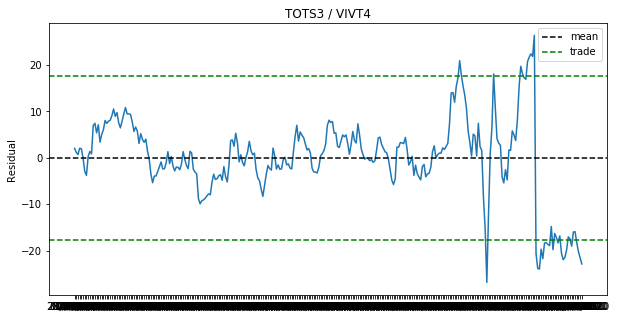

In [350]:
#show(data, 'CYRE3', 'MULT3')
show(data, 'TOTS3', 'VIVT4')

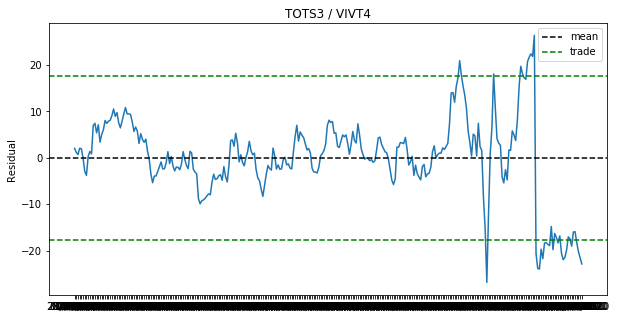

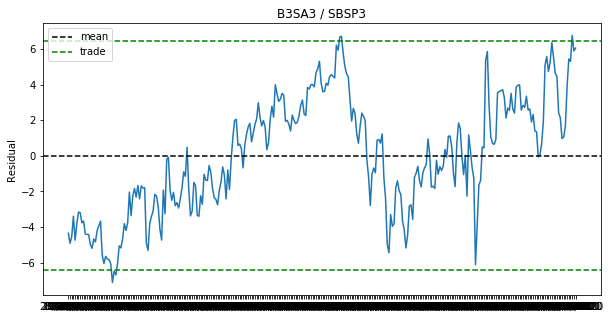

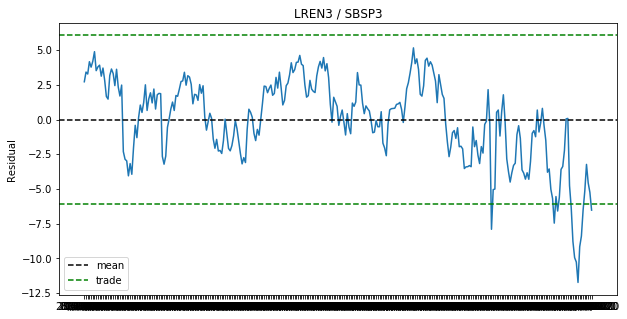

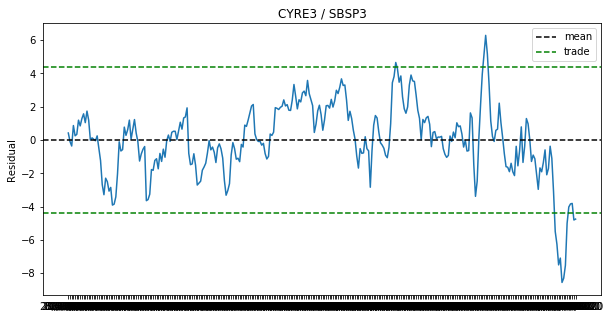

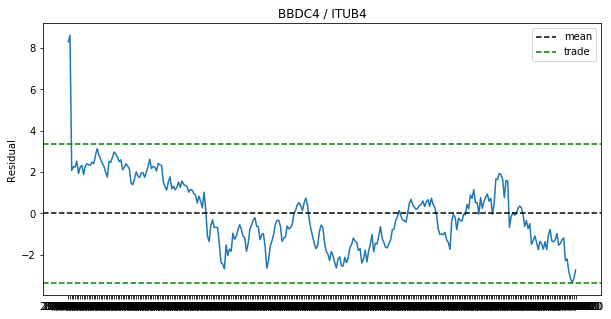

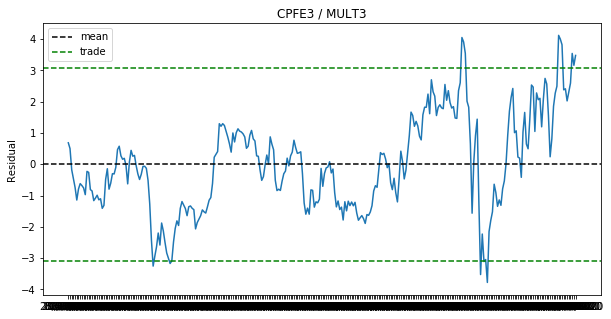

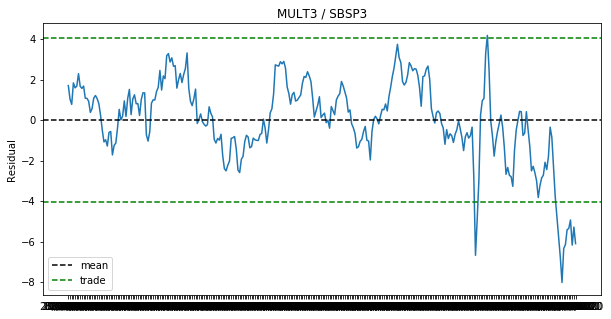

In [356]:
for i, j in oper.iterrows():
    show(data, j['Dependente'], j['Independente'])